In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

import datetime
from datetime import date

# Plots
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

# Classifier's metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# 1. Preprocesing data

### 1.1 Retrieve data

In [2]:
# Read dataset
data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [3]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### 1.2 Analyze data and rename columns

In [4]:
# Calculate client's age
data['Age'] = 2021 - data['Year_Birth']

# Calculate total spent
data['Total_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)

In [5]:
# Calculate clients's seniority
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')

# Rename some columns
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",
                          'NumCatalogPurchases':'Catalog_Purchases',
                          'NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month',
                          'MntWines': "Wines",
                          'MntFruits':'Fruits',
                          'MntMeatProducts':'Meat',
                          'MntFishProducts':'Fish',
                          'MntSweetProducts':'Sweets',
                          'MntGoldProds':'Gold'})
data['Marital_Status'].replace({'Absurd':'Alone','YOLO':'Alone'}, inplace=True)

# Calculate the amount of children that a client has
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_Child'] = (data.Children > 0)*1
# Filter just relevant client's features
data=data[['Age','Education','Marital_Status','Income','Total_Spent','Seniority','Has_Child', 'Children', 'Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


In [6]:
def plot_hist(columns, bins):
    features = len(columns)
    COLUMNS = 4
    ROWS = math.ceil(features/COLUMNS)

    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(16,10))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        current_row = i//COLUMNS
        # Get the axis where to add the plot
        ax = axs[current_row, current_column]
        data[columns[i]].hist(bins=bins[i], ax=ax, alpha=0.6)
        ax.set_title(columns[i])
        
    plt.tight_layout()

In [7]:
def plot_bars(columns):
    features = len(columns)
    COLUMNS = 4
    fig, axs = plt.subplots(1, COLUMNS, figsize=(16,4))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        ax = axs[current_column]
        data[columns[i]].value_counts().plot(ax=ax, kind='bar')
        ax.set_title(columns[i])
        
    plt.tight_layout()

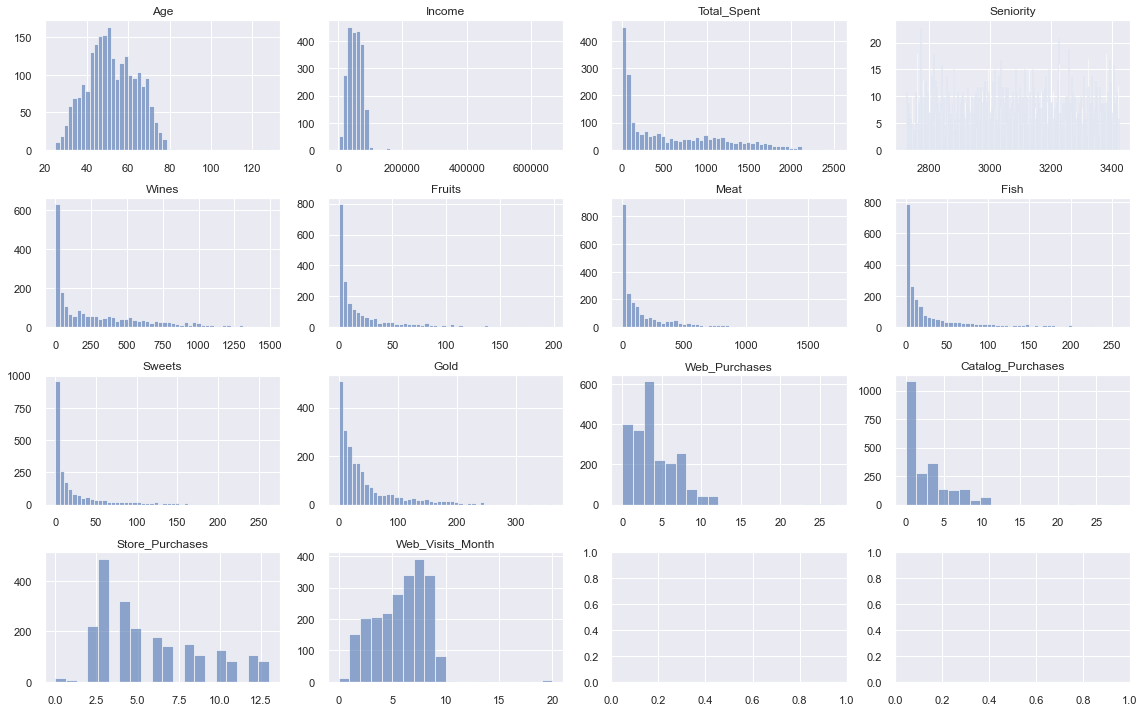

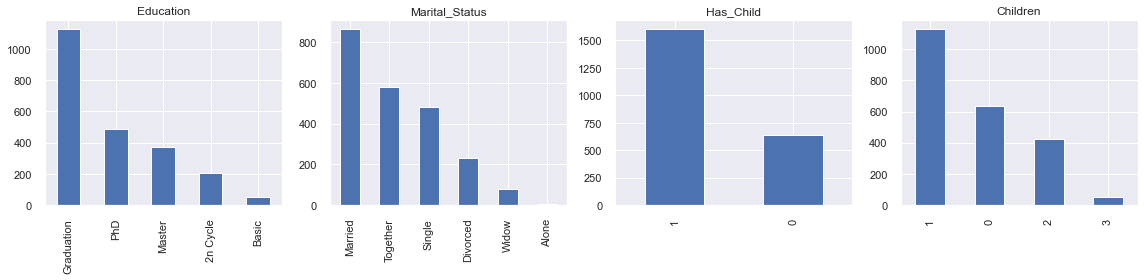

In [8]:
# Plot features after cleaning the data
hist_columns = ['Age', 'Income', 'Total_Spent', 'Seniority', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
bar_columns = ['Education', 'Marital_Status', 'Has_Child', 'Children']

bins = [50, 50, 50, 250, 50, 50, 50, 50, 50, 50, 20, 20, 20, 20]

plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### 1.3 Clean data

In [9]:
# Check amount of initial null values
data_info = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(data.columns)):
    data_info.loc[i] = [data.columns[i],
                        data[data.columns[i]].isnull().sum(),
                        data[data.columns[i]].dtypes,
                        data[data.columns[i]].nunique()] 
    
data_info

,Name of Col,Num of Null,Dtype,N_Unique
0,Age,0,int64,59
1,Education,0,object,5
2,Marital_Status,0,object,6
3,Income,24,float64,1974
4,Total_Spent,0,int64,1054
5,Seniority,0,int16,663
6,Has_Child,0,int32,2
7,Children,0,int64,4
8,Wines,0,int64,776
9,Fruits,0,int64,158


In [10]:
# Fill null values with median income amount according its education level
data['Income'].fillna(data.groupby('Education')['Income'].transform('median'), inplace=True)

In [11]:
# Check the amount of null values after cleaning the data
print('Amount of null values after cleaning the data',len(data[data.isna().any(axis=1)]))

Amount of null values after cleaning the data 0


### 1.4 Remove outliers

In [12]:
def plot_outliers(data, x):
    fig, axes = plt.subplots(2, 1, figsize=(10,6))

    sns.boxplot(data = data, x = x, color = 'red', ax = axes[0])
    sns.histplot(data = data, x = x, kde=True, color='blue', ax = axes[1])
    plt.show()

#### 1.4.1 Income outliers

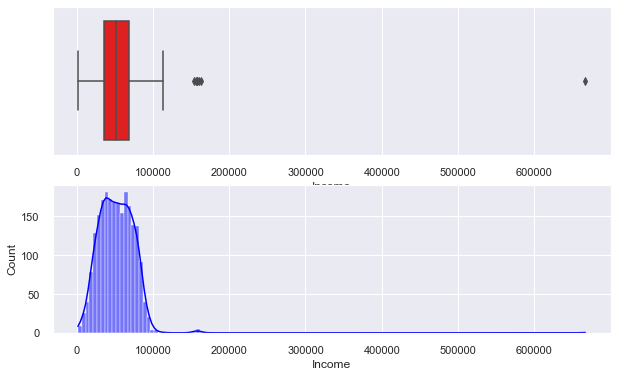

In [13]:
# Plot Income data with outliers
plot_outliers(data, 'Income')

In [14]:
# Define the function for capping the outliers
def cap_outliers(data, x):
    print(f'old shape: {data.shape}')
    q1 = data[x].quantile(0.25)
    q3 = data[x].quantile(0.75)

    iqr = q3 - q1

    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    print(f'upper bound value: {upper_bound}')
    print(f'lower bound value: {lower_bound}')

    data.loc[data[x] > upper_bound, x] = upper_bound
    data.loc[data[x] < lower_bound, x] = lower_bound

    print(f'new shape: {data.shape}, There is no change of the shape.')

In [15]:
# Remove outliers
cap_outliers(data, 'Income')

old shape: (2240, 18)
upper bound value: 117416.25
lower bound value: -13587.75
new shape: (2240, 18), There is no change of the shape.


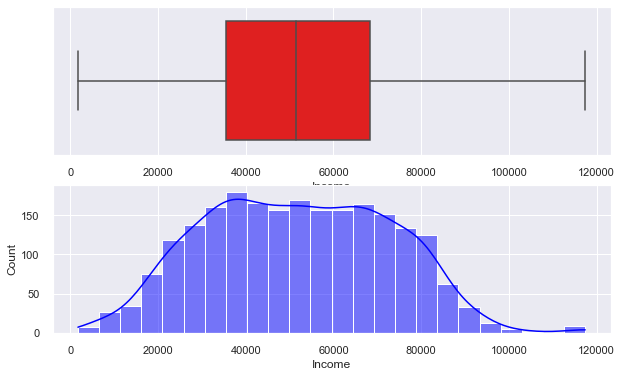

In [16]:
# Plot Income data without outliers
plot_outliers(data, 'Income')

#### 1.4.2 Age outliers

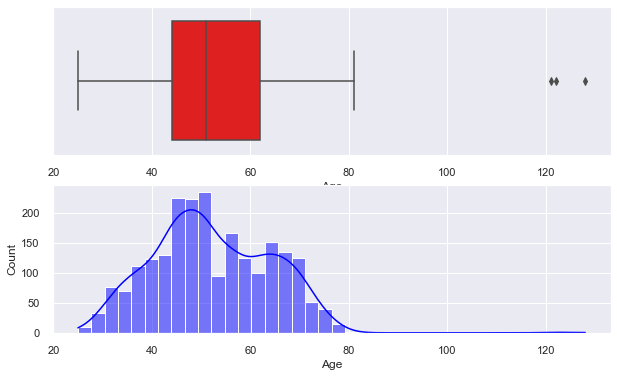

In [17]:
# Plot Age data with outliers
plot_outliers(data, 'Age')

In [18]:
# Capping outliers
cap_outliers(data, 'Age')

old shape: (2240, 18)
upper bound value: 89.0
lower bound value: 17.0
new shape: (2240, 18), There is no change of the shape.


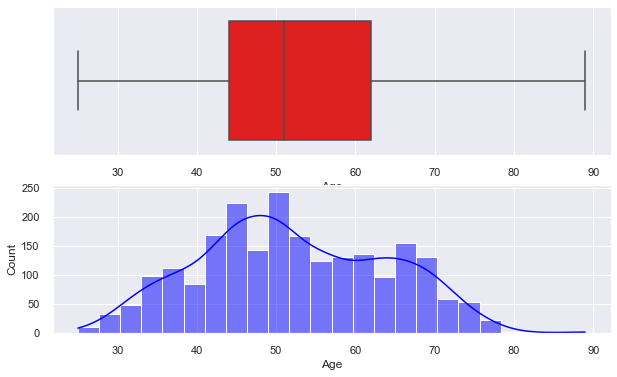

In [19]:
# Plot Age data without outliers
plot_outliers(data, 'Age')

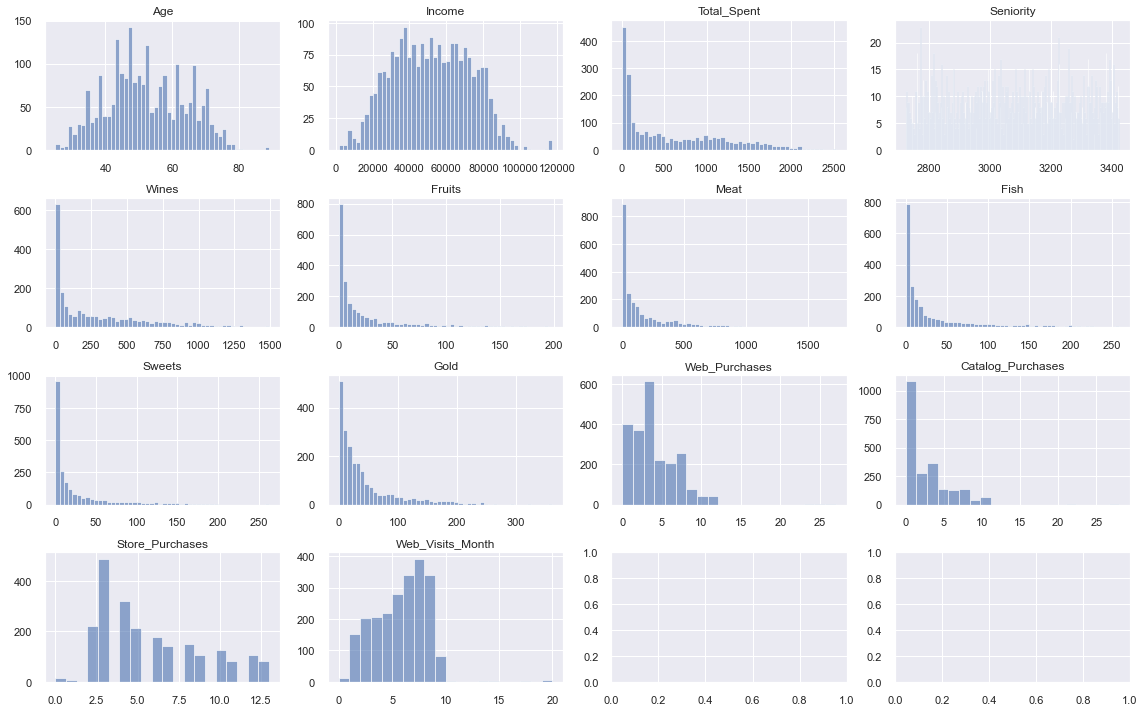

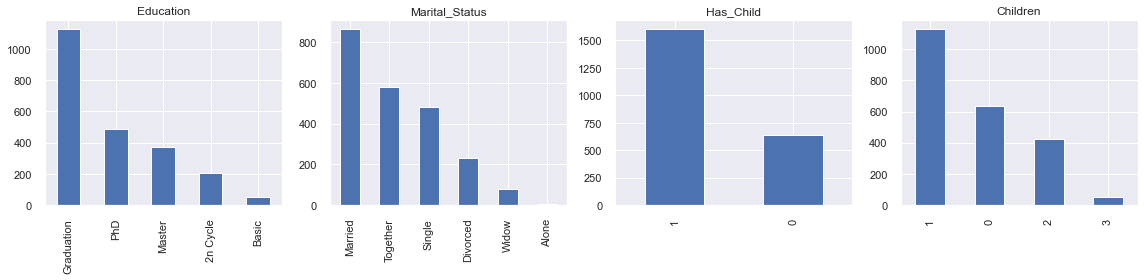

In [20]:
# Plot again after cleaning the data
plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### 1.5 Correlation Analysis

<AxesSubplot:>

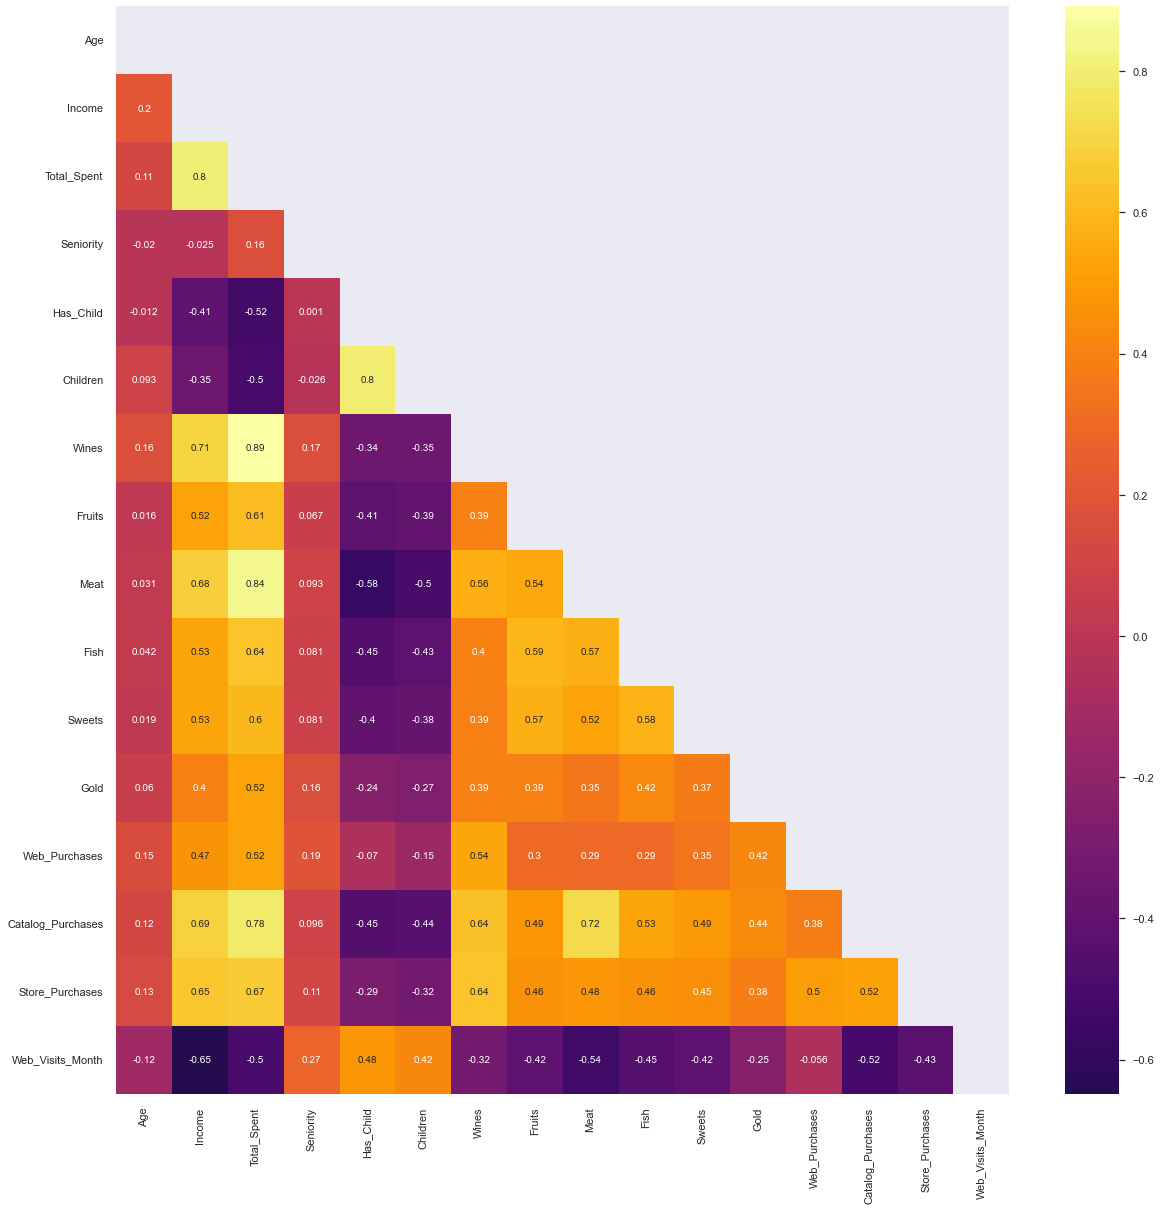

In [21]:
corrmat= data.corr()

plt.figure(figsize=(20,20))

mask = np.zeros_like(corrmat, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat, annot=True, cmap='inferno', mask=mask, center=0)

### 1.6 Prepare data

In [22]:
data_to_plot = data
data = pd.get_dummies(data)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,1,0,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,1,0,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,1,0,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,1,0,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,1,0,0,1,0,0,0


In [23]:
# Adding labels to DataFrame
data['Buy_More_Online'] = (data['Web_Purchases'] > data['Store_Purchases'])*1
data['Spent_More_In_Wines_Than_Meat'] = (data['Wines'] > data['Meat'])*1

In [24]:
# Get own labels
y_online = data['Buy_More_Online']
y_spent = data['Spent_More_In_Wines_Than_Meat']

In [25]:
# Drop label columns
data.drop(columns=['Buy_More_Online', 'Spent_More_In_Wines_Than_Meat'], inplace=True)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,1,0,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,1,0,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,1,0,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,1,0,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,1,0,0,1,0,0,0


# 2. Unsupervised Learning

### 2.1 Standarize data

In [26]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Standarized = scaler.fit(data[numeric_columns]).transform(data[numeric_columns])
X_Standarized

array([[ 1.00706384,  0.29941028,  1.53118494, ...,  2.51089024,
        -0.55078479,  0.69390374],
       [ 1.2619687 , -0.26401077, -1.19054458, ..., -0.56871962,
        -1.1661254 , -0.13046347],
       [ 0.32731756,  0.94313578, -0.20577336, ..., -0.22654075,
         1.29523705, -0.54264708],
       ...,
       [-1.032175  ,  0.24413826, -0.98270342, ...,  0.11563813,
         2.21824797,  0.28172013],
       [ 1.09203213,  0.83001207, -0.97775482, ...,  0.79999587,
         1.29523705, -0.95483068],
       [ 1.2619687 ,  0.04770047,  1.32829237, ..., -0.56871962,
        -0.55078479,  0.69390374]])

In [27]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in data.columns if c not in numeric_columns]
X_Standarized = pd.DataFrame(X_Standarized, columns=numeric_columns)
X_complete = pd.concat([X_Standarized, data[cat_cols].reset_index(drop=True)], axis=1)
X_complete

,Age,Income,Seniority,Total_Spent,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.007064,0.299410,1.531185,1.679417,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,...,0,1,0,0,0,0,0,1,0,0
1,1.261969,-0.264011,-1.190545,-0.961275,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,...,0,1,0,0,0,0,0,1,0,0
2,0.327318,0.943136,-0.205773,0.282673,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,...,0,1,0,0,0,0,0,0,1,0
3,-1.287080,-1.205020,-1.061881,-0.918094,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,...,0,1,0,0,0,0,0,0,1,0
4,-1.032175,0.306815,-0.953012,-0.305254,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.157381,0.446786,0.135680,1.221032,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,...,0,1,0,0,0,0,1,0,0,0
2236,1.941715,0.580118,-1.655713,-0.268717,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,...,0,0,0,1,0,0,0,0,1,0
2237,-1.032175,0.244138,-0.982703,1.054951,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,...,0,1,0,0,0,1,0,0,0,0
2238,1.092032,0.830012,-0.977755,0.393948,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,...,0,0,1,0,0,0,0,0,1,0


In [28]:
# Quick examination of elbow method to find numbers of clusters to make.
def get_best_k(x):
    Elbow_M = KElbowVisualizer(KMeans(random_state=0), k=10)
    Elbow_M.fit(x)
    Elbow_M.show()

### 2.2 Fit_predict without PCA

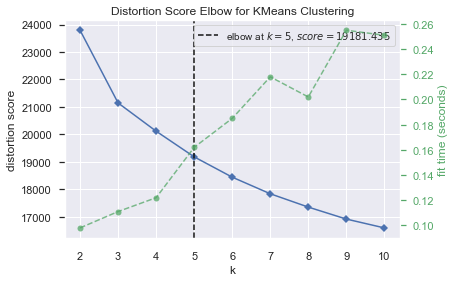

In [29]:
# Elbow method
get_best_k(X_complete)

In [30]:
# Get KMeans labels
best_k = 5
labels = KMeans(n_clusters=best_k, random_state=0).fit_predict(X_complete)

In [31]:
data_to_plot['Cluster'] = labels
data_to_plot

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month,Cluster
ID,,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7,4
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5,0
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4,2
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6,0
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,54,Graduation,Married,61223.0,1341,3105,1,1,709,43,182,42,118,247,9,3,4,5,4
4001,75,PhD,Together,64014.0,444,2743,1,3,406,0,30,0,0,8,8,2,5,7,0
7270,40,Graduation,Divorced,56981.0,1241,2879,0,0,908,48,217,32,12,24,2,3,13,6,2


### 2.3 Fit_predict with PCA

In [32]:
#Initiating PCA to reduce dimentions aka features to 3
X_PCA = PCA(n_components=3).fit(X_complete).transform(X_complete)
PCA_ds = pd.DataFrame(X_PCA, columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2240.0,-1.194481e-16,2.639371,-4.975351,-2.437419,-0.754081,2.283775,7.338571
col2,2240.0,-4.282289e-17,1.218664,-3.888091,-0.887213,-0.094164,0.826648,3.980597
col3,2240.0,2.423657e-17,1.105956,-3.255543,-0.789688,-0.018004,0.772369,3.963715


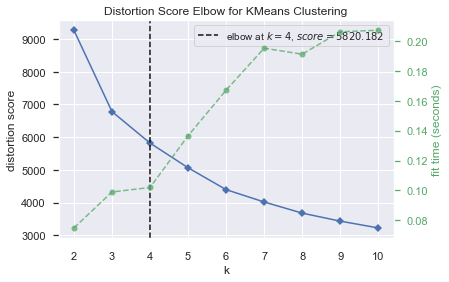

In [33]:
# Elbow method
get_best_k(PCA_ds)

In [34]:
# Get KMeans labels
best_k_PCA = 4
labels_PCA = KMeans(n_clusters=best_k_PCA, random_state=0).fit_predict(X_complete)

In [35]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds['col1']
y =PCA_ds['col2']
z =PCA_ds['col3']
PCA_ds['Clusters_PCA'] = labels_PCA
data_to_plot['Clusters_PCA'] = labels_PCA

In [36]:
PCA_ds

,col1,col2,col3,Clusters_PCA
0,4.284840,1.245706,1.396598,2
1,-2.462409,-1.165781,-1.433178,0
2,1.886529,0.108756,-0.375239,1
3,-2.597580,-1.073814,0.672454,0
4,-0.144566,-0.793435,0.153786,0
...,...,...,...,...
2235,2.799127,1.672469,0.663661,1
2236,-1.019770,0.826534,-3.255543,0
2237,1.558786,-0.451374,0.000057,1
2238,1.875240,-0.365737,-1.672321,1


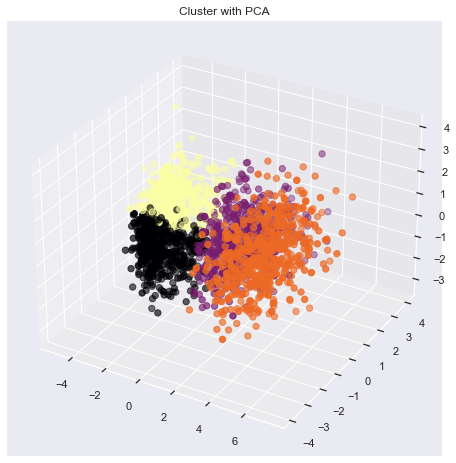

In [37]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds['Clusters_PCA'], marker='o', cmap='inferno')
ax.set_title("Cluster with PCA")
plt.show()

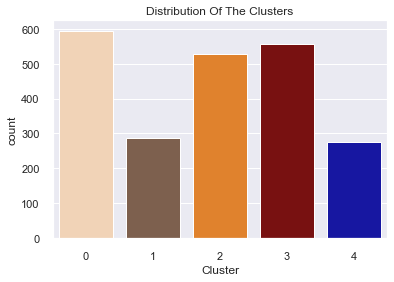

In [38]:
#Plotting countplot of clusters
pal = ['#FAD3AE', '#855E46', '#FE800F', '#890000', '#0000B8']
pl = sns.countplot(x=data_to_plot['Cluster'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

#### 2.3.1 Customers Profiling

* Purchasing behavior by clusters: 
'Spent_All', 'PurDeal_PurAll_ratio', 'NumWebVisitsMonth', 'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases'
* Personal information by clusters
'Income', 'Age', 'Education', 'Is_Parent', Family_Size', 'Kidhome', 'Teenhome'

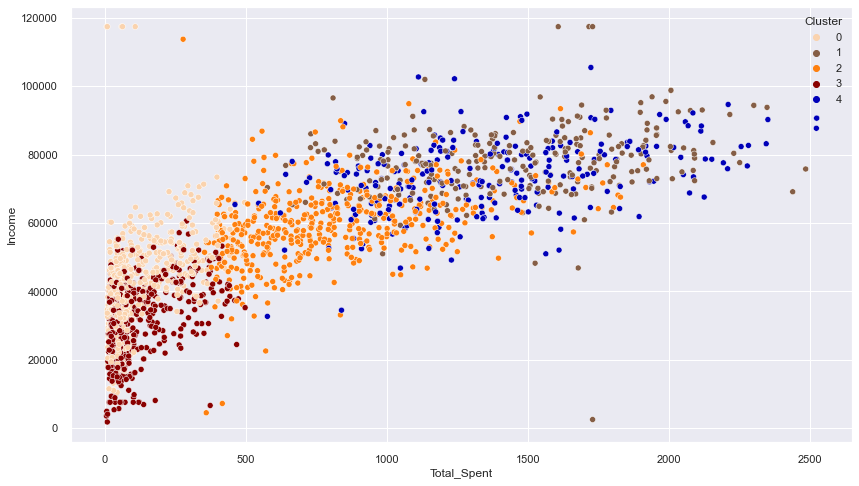

In [39]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=data_to_plot["Total_Spent"], y=data_to_plot["Income"], hue=data_to_plot["Cluster"], palette=pal);

* Group 0: low spend - low income
* Group 1: high spend - average income
* Group 2: high spend - high income
* Group 3: low spend - average income

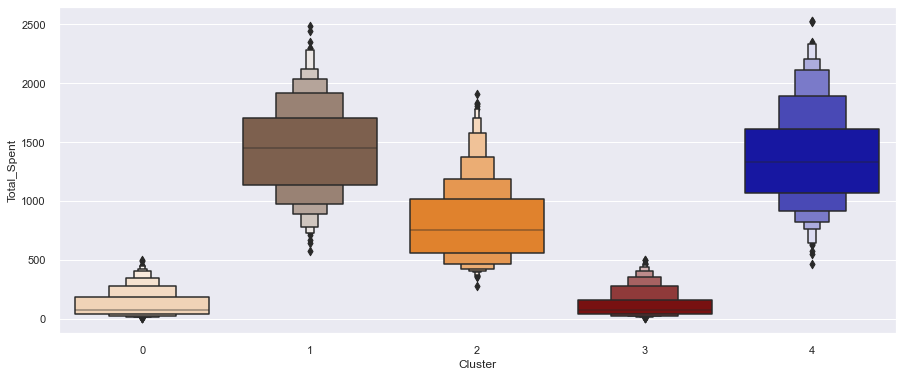

In [40]:
plt.figure(figsize=(15,6))
pl=sns.boxenplot(x=data_to_plot["Cluster"], y=data_to_plot["Total_Spent"], palette=pal)
plt.show()


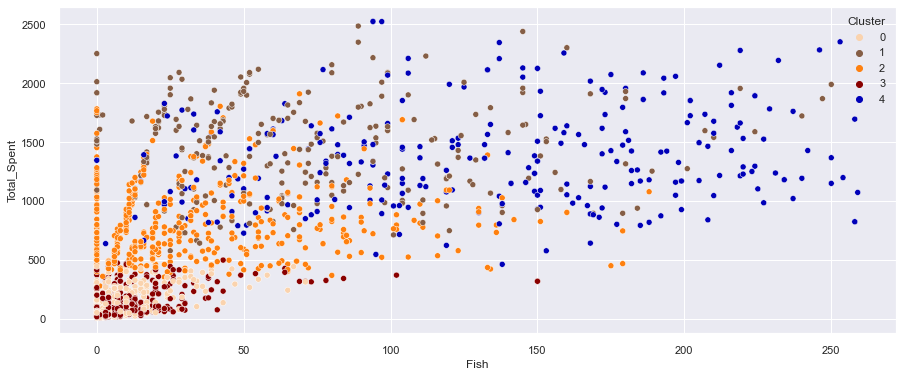

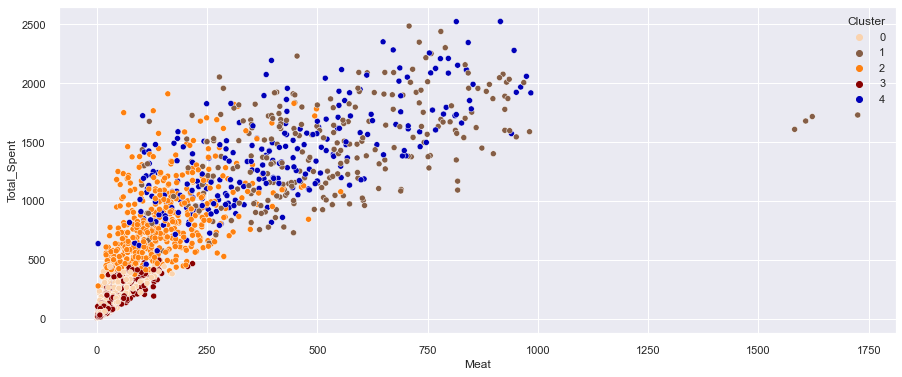

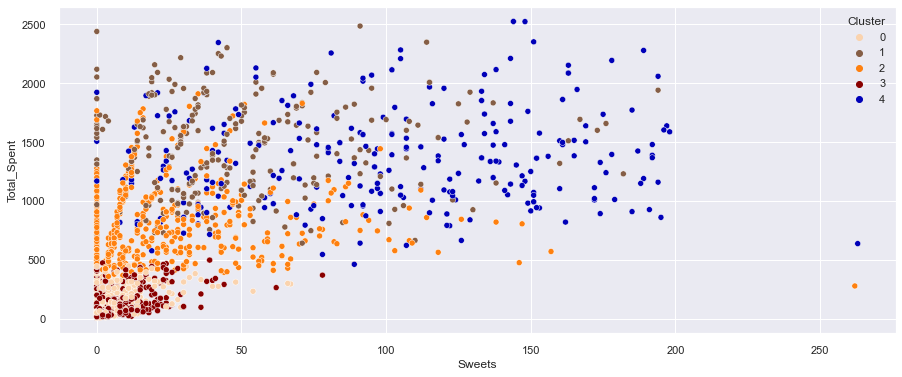

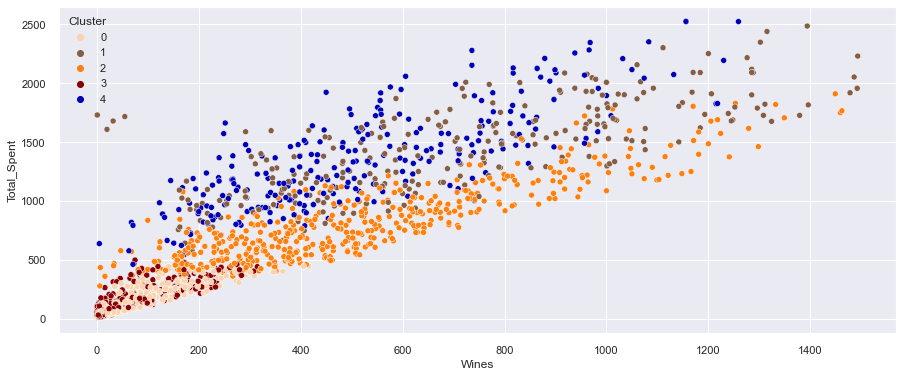

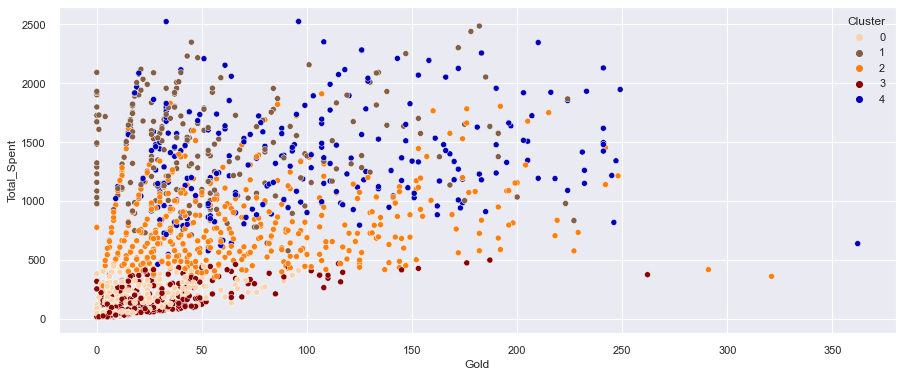

In [41]:
prod = ['Fish', 'Meat', 'Sweets', 'Wines', 'Gold']
for i in prod:
    plt.figure(figsize=(15,6))
    sns.scatterplot(x=i, y="Total_Spent", palette=pal ,data=data_to_plot, hue=data_to_plot["Cluster"]);

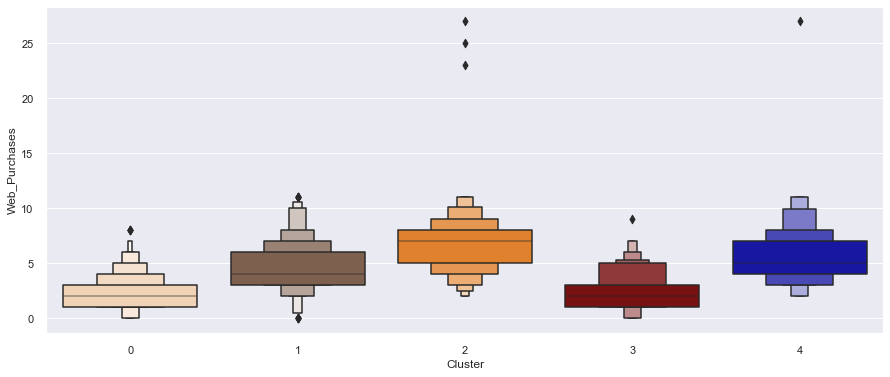

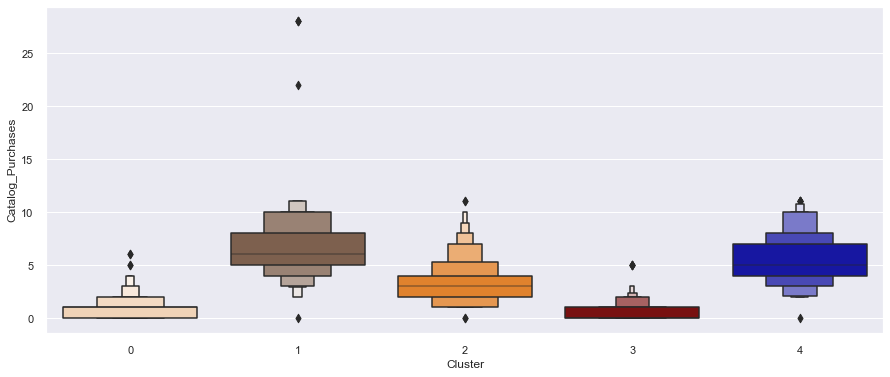

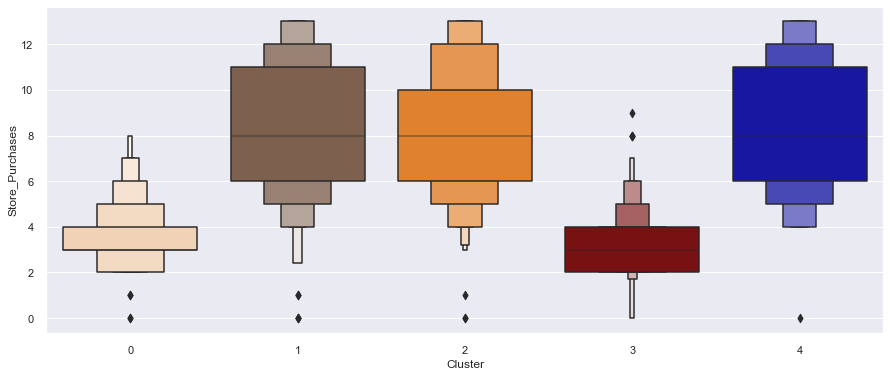

In [42]:
place = ["Web_Purchases", "Catalog_Purchases", "Store_Purchases"]
for i in place:
    plt.figure(figsize=(15,6))
    sns.boxenplot(x="Cluster", y=i, palette=pal ,data=data_to_plot);
    plt.show()

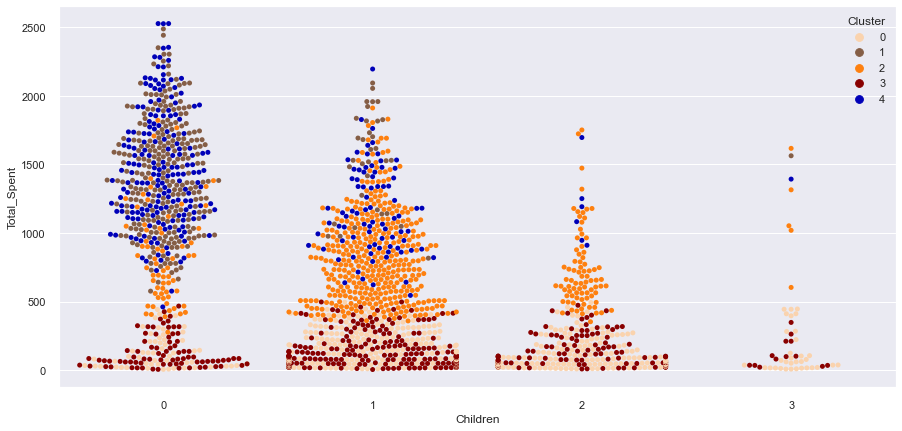

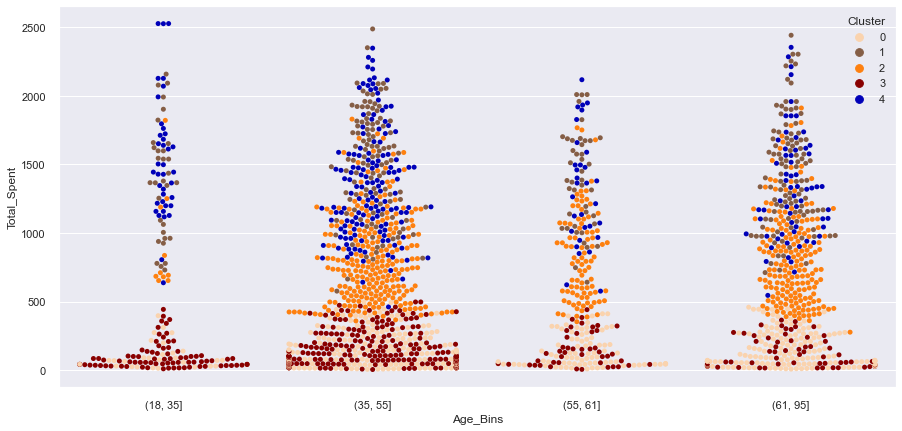

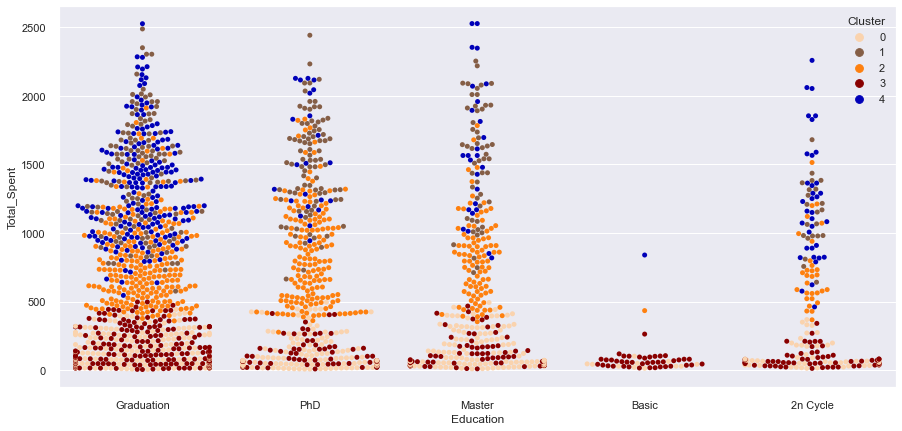

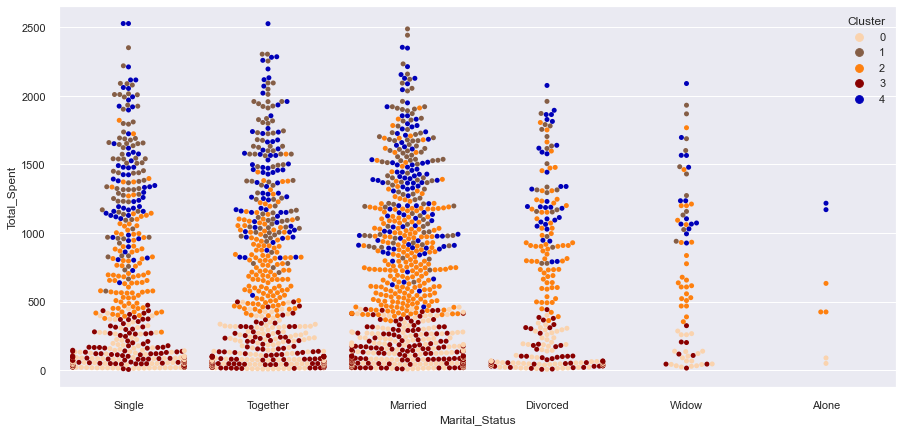

In [43]:
data_to_plot["Age_Bins"] = pd.cut(x=data["Age"], bins=[18,35,55,61,95])
prf = ["Children", "Age_Bins", "Education", "Marital_Status"]
for i in prf:
    plt.figure(figsize=(15,7))
    sns.swarmplot(x=i, y="Total_Spent", hue="Cluster", palette=pal ,data=data_to_plot)
    plt.show()

# 3. Supervised Learning

### 3.1 First Model: (Online purchases vs storage purchases)

In [44]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_online, test_size = 0.20)

#### 3.1.1 Standarization

In [45]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])
X_Train_Standarized

array([[-0.68450381, -1.46753022,  0.36605273, ..., -0.56295367,
        -1.1683989 ,  1.08933411],
       [ 1.49662062,  0.92262953,  0.72375508, ...,  1.12458895,
         2.22257271, -0.53132734],
       [-0.3489462 ,  1.6253344 , -1.59137402, ...,  1.12458895,
         0.37295183, -1.34165807],
       ...,
       [ 0.322169  , -0.23206282, -0.24999021, ..., -0.56295367,
        -0.55185861, -0.53132734],
       [-1.10395081,  0.29464398, -1.08462903, ...,  0.4495719 ,
         0.98949212, -0.93649271],
       [-0.6006144 , -1.50572433,  0.70885082, ..., -0.56295367,
        -0.55185861,  0.68416874]])

In [46]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)

#### 3.1.2 Train Model (Stochastic Gradient Descent)

In [47]:
# Stochastic Gradient Descent
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=200, alpha=0.1)

sgd.fit(X_Train_complete, y_train)
predict_sgd = sgd.predict(X_Test_complete)
print(predict_sgd)

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0]


#### 3.1.3 Plot Confusion Matrix

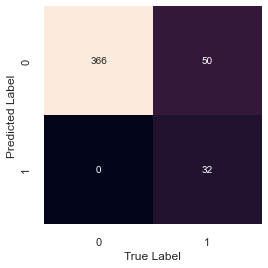

In [48]:
matrix = confusion_matrix(y_test, predict_sgd)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.show()

#### 3.1.4 Calculate classifier's metrics

In [49]:
accuracy = accuracy_score(y_test, predict_sgd)
print(f"Accuracy Score: {accuracy} ")
precision = precision_score(y_test, predict_sgd, average="binary", zero_division=1)
print(f"Precision Score: {precision} ")
recall = recall_score(y_test, predict_sgd, average="binary")
print(f"Recall Score: {recall} ")
f1score = f1_score(y_test, predict_sgd, average="binary")
print(f"F1 Score: {f1score} ")

Accuracy Score: 0.8883928571428571 
Precision Score: 1.0 
Recall Score: 0.3902439024390244 
F1 Score: 0.5614035087719299 


### 3.2 Second Model: (Spent more in Wine than Meat)

#### 3.2.1 Standarization

In [50]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_spent, test_size = 0.20)

In [51]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])

In [52]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)

#### 3.2.2 Train Model (Naive Bayes)

In [53]:
# Naive Bayes
gnb = GaussianNB()

gnb.fit(X_Train_complete, y_train)
predict_gnb = gnb.predict(X_Test_complete)
print(predict_gnb)

[1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1]


#### 3.2.3 Plot Confusion Matrix

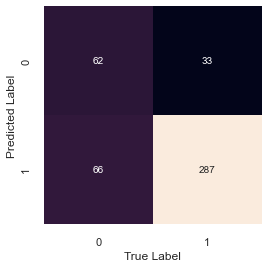

In [54]:
matrix = confusion_matrix(y_test, predict_gnb)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.show()

#### 3.2.4 Calculate classifier's metrics

In [55]:
accuracy = accuracy_score(y_test, predict_gnb)
print(f"Accuracy Score: {accuracy} ")
precision = precision_score(y_test, predict_gnb, average="binary", zero_division=1)
print(f"Precision Score: {precision} ")
recall = recall_score(y_test, predict_gnb, average="binary")
print(f"Recall Score: {recall} ")
f1score = f1_score(y_test, predict_gnb, average="binary")
print(f"F1 Score: {f1score} ")

Accuracy Score: 0.7790178571428571 
Precision Score: 0.8130311614730878 
Recall Score: 0.896875 
F1 Score: 0.8528974739970281 
